# The Curse of Dimensionality and Adaptive Sparse Grids

Julien Pascal: https://julienpascal.github.io/

Notebook for the blog post here: https://julienpascal.github.io/post/asg/


## Introduction

The **curse of dimensionality** is at the heart of dynamic programming. And dynamic programming is the cornerstone of modern economic theory. But what is the curse of dimensionality exactly? The aim of this blog post is to answer this question and to show one method that alleviates this curse: **adaptive sparse grids**. 

## I. Theory: the curse of dimensionality

### I. A. Problem 

The behavior of an optimizing agent can be summarized by a Bellman equation of the form:

$$ V(x,z) = \max_{c \in \Gamma(x,z)}[ F(x,c,z) + \beta E_{z'|z}[ V(T(x,c), z') ]$$ 

where $x$ is a **non-random** state variable and $z$ is a **random** variable following a Markov process. Both $x$ and $z$ are to be understood as vectors. The function $\Gamma(.)$ represents the set of possible actions given a current state and the function $T(.)$ captures the transition from one state to another when an action is taken. The variable $\beta$ is a discount factor striclty smaller than one and the $E$ represent an expectation operator.

Let's now assume that we know the policy function that dictates the optimal behavior of the agent $c^{\star} = g(x,z)$, so we can ignore the max operator and rewrite the above as:

$$ V(x,z) = F(x,c^{\star},z) + \beta E_{z'|z}[ V(T(x,c^{\star}), z') ]$$ 

---

Now let's leave the theoretical world. In practice one needs to **discretize (x,z) on a grid using a finite number of points**. Let's assume that the deterministic part of the state variable has $n$ dimensions and that the stochastic element has $z$ dimensions. For the sake of simplicity, let's assume that we use $k$ points along each dimension. To evaluate $V(x,z)$, $k^{n+z}$ operations are needed to evaluate $F(x,c^{\star},z)$ on the grid. 

Things get even worse if we look at the second element of the right-hand-side of the above equation: the conditional expectation. In the present context, a conditional expectation is "simply" a multidimensional integral. From a numerical standpoint, a multidimensional integral can be approximated using [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature). Once again, for the sake of simplicity let's assume we use $\omega$ nodes along each dimension for $z$. Then, Gaussian quadrature implies $w^z$ function evaluations for $V(.)$ for each point on the grid. So a grand total of $k^{n+z}w^{z}$ function evaluations, which is equal to $\exp[(n+z)log(k)+ zlog(w)]$.

---

From the formula $\exp[(n+z)log(k)+ zlog(w)]$, I see two main takeaways:

1. **Get rid of useless dimensions**. Yes, I know it's obvious, but the formula makes it clear. Dimensions show up linearly within the exponential function, while the number of discretization points enters logarithmically. We can save computation time by being smart for the choice of grid points, but the smartest move is to get rid of useless dimensions.

2. **Stochastic variables are more costly**. Once again it's obvious, but I like the formalism that the formula brings. Stochastic variables matter for today ($zlog(k)$), but also for tomorrow ($zlog(w)$). The choice of quadrature nodes is important ($log(w)$), but a reduction in $z$ would even be better.

Now let's plot the number of function evaluations necessary for the conditional expectation as a function of the number of dimensions for x and z (holding the number of grid points and the quadrature nodes constant). As illustrated below, **things get out of hand quite rapidly**.

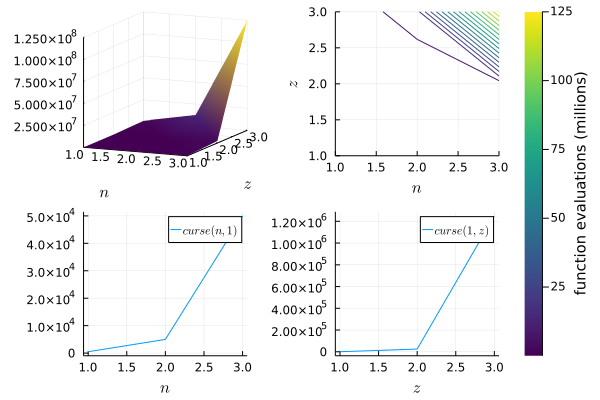

Millions of function evaluations for curse(3,3): 125.0


GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [62]:
using Plots
using LaTeXStrings
using IterTools
gr()

function curse(n,z; k=10, w=5)
    exp((n+z)*log(k) + z*log(w))
end

p1 = plot(1:3, 1:3, (n,z) -> curse(n,z), st=:surface, xlabel=L"n", ylabel=L"z", colorbar=false, c=:viridis)
p2 = plot(1:3, 1:3, (n,z) -> curse(n,z), st=:contour, xlabel=L"n", ylabel=L"z", colorbar=false, c=:viridis)
p3 = plot(1:3, n -> curse(n,1), label=L"curse(n,1)", xlabel=L"n")
p4 = plot(1:3, z -> curse(1,z), label=L"curse(1,z)", xlabel=L"z")

clims = extrema([curse(n,z) for (n,z) in product(1:3, 1:3)])./(10^6)
h2 = scatter([0,0], [0,1], zcolor=[0,3], clims=clims,
             xlims=(1,1.1), label="", c=:viridis, colorbar_title="function evaluations (millions)", framestyle=:none)

l = @layout [grid(2, 2) a{0.035w}]

p_all = plot(p1, p2, p3, p4, h2, layout=l)
display(p_all)
println("Millions of function evaluations for curse(3,3): $(round(curse(3,3)/(10^6), digits = 2))")

### I.B. One solution

One solution brought to the field of Economics by [Brumm and Scheidegger (2017)](https://johannesbrumm.com/wp-content/uploads/2017/09/Brumm-Scheidegger-2017-ECTA.pdf) is to use **adaptive sparse grids**. Adaptive sparse grids combine two ideas:

1. **Sparse** grids are based on the idea that when it comes to extrapolation power, not all grid points are born equal. Some grid points are to some extent redundant and can be avoided. 

2. **Adaptive** sparse grids use a sparse grid as a starting point. Additional points are then added to the (sparse) grid in regions of high curvature. 

Now let's look at how a sparse grid adapts to the curvature of the following **non-smooth function**:

$$ f(x,y) = \frac{1}{|0.5 - x^4 - y^4| + 0.1} $$

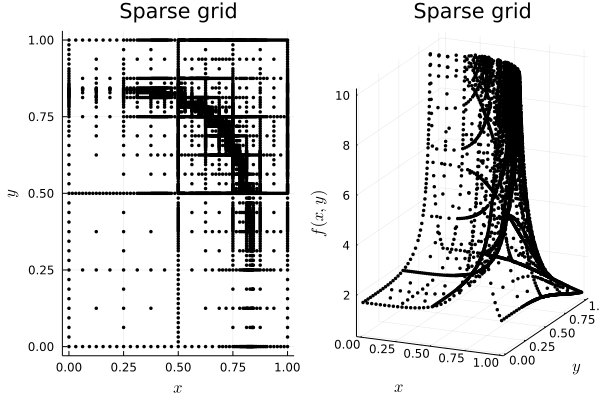

In [63]:
# Packages and helper functions
using AdaptiveSparseGrids
using Random
using Distributions
using DataFrames
using NBInclude
@nbinclude("utils.ipynb")

# Example taken from here: https://github.com/jacobadenbaum/AdaptiveSparseGrids.jl
# I made small modifications along the way
# Bounds
lb  = zeros(2)
ub  = ones(2)

# True function to approximate:
f(x) = 1.0/(abs(0.5 - x[1]^4 - x[2]^4) + 0.1)

# Construct approximation:
fun = AdaptiveSparseGrid(f, lb, ub,
                         max_depth = 10,    # The maximum depth of basis elements in each dimension
                         tol = 0.01)        # Add nodes when min(abs(alpha/f(x)), abs(alpha)) < tol

xy_grid = extract_grid(fun)
p1=scatter(xy_grid[:,1],xy_grid[:,2], m=(:black,2),title="Sparse grid", xlabel=L"x", ylabel=L"y")
p2 = plot(xy_grid[:,1],xy_grid[:,2], [fun(xy_grid[i,:]) for i in 1:size(xy_grid,1)], m=(:black,2),title="Sparse grid", xlabel=L"x", ylabel=L"y", zlabel=L"f(x,y)", st=:scatter3d)
plot(p1, p2, legend=false)

## II. Application

Alright, back to Economics. We will focus on the model of the labour market by [Lise and Robin](https://www.aeaweb.org/articles?id=10.1257/aer.20131118). You can take a look at the original paper, or at my previous post [here](https://julienpascal.github.io/post/ann_2/). "Solving the model" involves finding the function solving the following equation:

$$ S(x,y,z) = s(x,y,z) + \frac{1 - \delta}{1 + r} E_{z'|z} [ max(S(x,y,z'), 0) ] $$ 

### II. A. Value function iteration with a full grid

For more details on value function iteration with a dense grid, you can look at my [former post here](https://julienpascal.github.io/post/ann_2/). The two blocks of code below solve for the unknow function
$S(.)$ and plot the results for a dense grid.

In [64]:
# Type defined in "utils.ipynb"
p = Params(nx=21, ny=21, nz=10);
# Solve by dense value function iteration
# function defined in "utils.ipynb"
@time S_dense = solve_VFI(p, max_iter = 5000) 

Iter 1312 Convergence reached
 52.039330 seconds (581.92 M allocations: 25.138 GiB, 8.56% gc time, 1.30% compilation time)


#493 (generic function with 1 method)

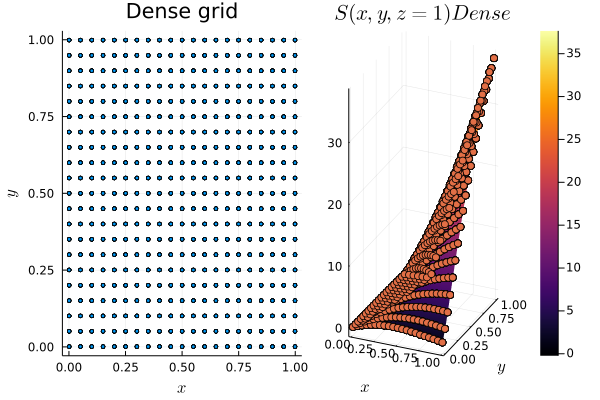

In [65]:
# Reshape the grid
vals_grid = zeros(size(p.x_grid,1)*size(p.y_grid,1)*size(p.z_grid,1), 3)
for (i, (x, y, z)) in enumerate(product(p.x_grid, p.y_grid, p.z_grid))
    vals_grid[i, 1] = x
    vals_grid[i, 2] = y
    vals_grid[i, 3] = z
end

# Plot dense VFI
p1=scatter(vals_grid[:,1], vals_grid[:,2],m=(2),title="Dense grid", xlabel=L"x", ylabel=L"y")
p2 = plot(p.x_grid, p.y_grid, (x, y) -> S_dense([x; y; 1.0])[1], label = "f(x)", st=:surface)
plot!(vals_grid[:,1], vals_grid[:,2], [S_dense([vals_grid[i,1]; vals_grid[i,2]; 1.0])[1] for i in 1:size(vals_grid,1)], label = "f(x)", st=:scatter3d)
title!(L"S(x,y,z=1) Dense")
xlabel!(L"x")
ylabel!(L"y")

plot(p1, p2, legend=false)

### II.C. Adaptive sparse grid

Now let's solve the same problem using the methodology described in [Brumm and Scheidegger (2017)](https://johannesbrumm.com/wp-content/uploads/2017/09/Brumm-Scheidegger-2017-ECTA.pdf) (without the fancy parallelism that they use). The idea is to **start with a sparse grid** and to **add points to the grid where the 
function is non-smooth**. The following block of code does that and compare the results obtained previously with the dense grid. Both methods yield same results, despite the sparse grid having fewer points.

In [66]:
# A. Initialization of the RHS
function init_guess(x, p)
    p.s_xyz(x[1], x[2], x[3]) + ((1.0 - p.delta)/(1.0 + p.r))*max(0.0, p.s_xyz(x[1], x[2], x[3]))
end

# Construct our approximation (this will evaluate f at the needed points, using
# all available threads)
fun = AdaptiveSparseGrid(x -> init_guess(x, p), p.lower_bound, p.upper_bound,
                         max_depth = 5,    # The maximum depth of basis elements in 
                                            # each dimension
                         tol = 0.015)        # Add nodes when 
                                            # min(abs(alpha/f(x)), abs(alpha)) < tol
fun_init = deepcopy(fun)
xyz_grid = extract_grid(fun)
pred_old = [fun(xyz_grid[i,:]) for i in 1:size(xyz_grid,1)]

# B. Function that calculate the RHS of the Bellman equation, given the guess from the previous iteration
function RHS(x, p, fun_old)

    vals = zeros(p.nb_nodes, 3)
    for (k, innovation) in enumerate(p.nodes_E)
        vals[k,1] = x[1]
        vals[k,2] = x[2]
        #Have to use min(max()) to stay within the boundaries (no extrapolation allowed)
        vals[k,3] = min(max(fun.bounds[3,1], (x[3].^p.rho).*exp.(innovation)), fun.bounds[3,2])
    end

    p.s_xyz(x[1], x[2], x[3]) + ((1.0 - p.delta)/(1.0 + p.r)).*sum(p.weigths_E.*max.(0.0, [fun_old(vals[i,:]) for i in 1:size(vals, 1) ]))

end

# C. Solve the problem with adaptive sparse grid
# parameters for VFI
tol_VF = 1e-8 #tolerance for VFI
max_iter_VF = 5000 #max iterations for VFI
show_every = max_iter_VF #display difference
# initialize values
fun_old = deepcopy(fun_init)
pred_old = [fun_old(xyz_grid[i,:]) for i in 1:size(xyz_grid,1)]
max_depth = 5 #max depth for sparse grid
tol = 0.015 #tolerance on sparse grid

@time begin
    # Initialize
    for i = 1:max_iter_VF
   
        fun = AdaptiveSparseGrid(x -> RHS(x, p, fun_old), p.lower_bound, p.upper_bound,
                         max_depth = max_depth,    # The maximum depth of basis elements in 
                                            # each dimension
                         tol = tol)        # Add nodes when 
                                            # min(abs(alpha/f(x)), abs(alpha)) < tol

        # Prediction on fixed grid
        pred_new = [fun(xyz_grid[i,:]) for i in 1:size(xyz_grid,1)]
        
        # DISTANCE
        # Check on fixed grid
        diff= maximum(abs.(pred_new .- pred_old))
        if mod(i, show_every) == 0
            println("Iter $(i) Diff : $(diff)")
            println("Max nb points on sparse grid: $(length(fun.nodes))")
        end
        
        if diff < tol_VF
            println("Iter $(i) Convergence reached")
            break
        end

        #UPDATE
        pred_old = copy(pred_new)
        fun_old = deepcopy(fun)

    end
end



Iter 1297 Convergence reached
 61.905844 seconds (435.70 M allocations: 17.782 GiB, 3.73% gc time, 0.95% compilation time)


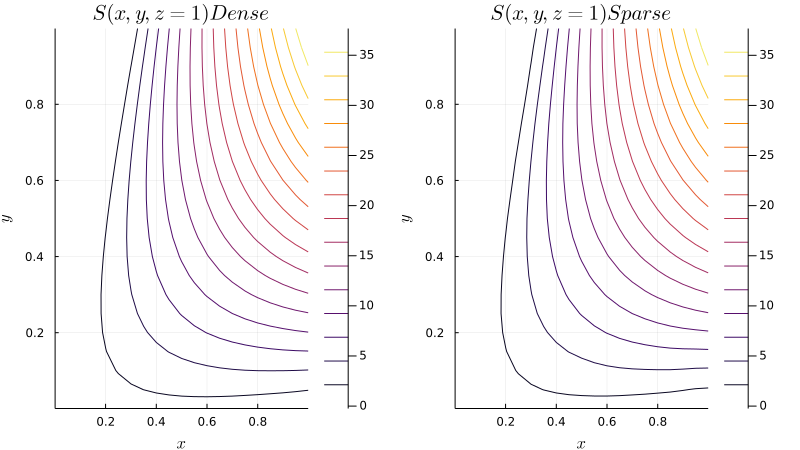

In [67]:
# Plot output
p1 = plot(p.x_grid, p.y_grid, (x, y) -> S_dense([x; y; 1.0])[1], label = "f(x)", st=:contour)
title!(L"S(x,y,z=1) Dense")
xlabel!(L"x")
ylabel!(L"y")

# Initialization function
xyz_grid = extract_grid(fun)
p2 = plot(p.x_grid, p.y_grid, (x, y) -> fun([x;y;1.0]), label = "f(x)", st=:contour)
title!(L"S(x,y,z=1) Sparse")
xlabel!(L"x")
ylabel!(L"y")

ratio = 9/16
width = 800
pp = plot(p1, p2, size = (width, width*ratio))

### II.D. Sparse grid versus full grid

As illustrated below, the sparse grid puts **more points where the function $S(.)$ changes sign** (in the top left and the bottom right parts of the (x-y) space). It matters because the sign of $S(.)$ determines whether or not a job is feasible for a worker of type $x$ and a firm of productivity $y$.

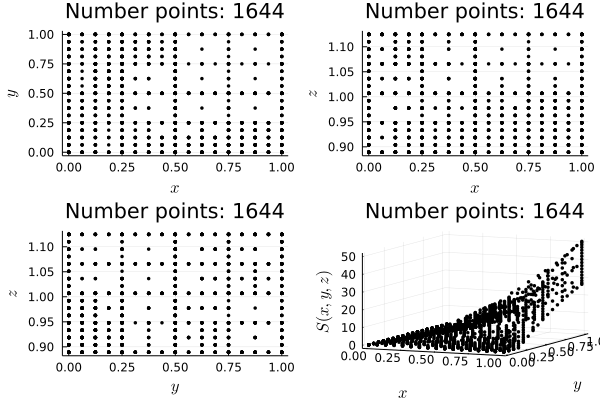

In [68]:
p1=scatter(xyz_grid[:,1], xyz_grid[:,2], m=(:black,2),title="Sparse grid", xlabel=L"x", ylabel=L"y")
p2=scatter(xyz_grid[:,1], xyz_grid[:,3], m=(:black,2),title="Sparse grid", xlabel=L"x", ylabel=L"z")
p3=scatter(xyz_grid[:,2], xyz_grid[:,3], m=(:black,2),title="Sparse grid", xlabel=L"y", ylabel=L"z")
p4 = plot(xyz_grid[:,1], xyz_grid[:,2], [fun(xyz_grid[i,:]) for i in 1:size(xyz_grid,1)], m=(:black,2),title="Sparse grid", st=:scatter3d, xlabel=L"x", ylabel=L"y", zlabel=L"S(x,y,z)")
plot(p1, p2, p3, p4, legend=false, title="Number points: $(size(xyz_grid, 1))")

### II.E. Accuracy

Looking at the mean squared error, or the median squared error, the adaptive sparse grid method is **more accurate**. This holds despite the fact that the sparse grid has approximately **four time less points**.

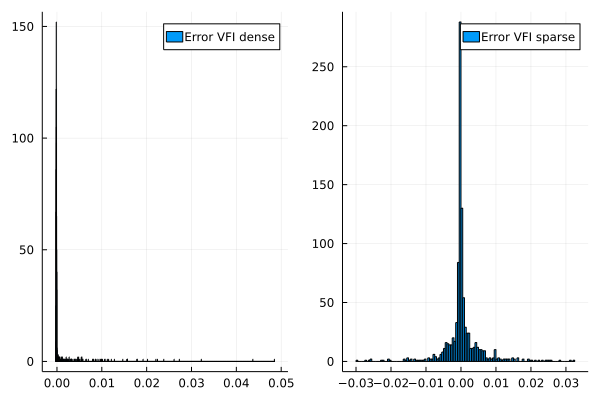

In [69]:
#Random draws from space
nb_draws = 1000
x_grid_rand = rand(Uniform(p.lower_bound[1], p.upper_bound[1]), nb_draws)
y_grid_rand = rand(Uniform(p.lower_bound[2], p.upper_bound[2]), nb_draws)
z_grid_rand = rand(Uniform(p.lower_bound[3], p.upper_bound[3]), nb_draws);

#LHS
LHS_dense = zeros(nb_draws)
LHS_sparse = zeros(nb_draws)
for (index, (xValue, yValue, zValue)) in enumerate(zip(x_grid_rand, y_grid_rand, z_grid_rand))
    LHS_dense[index] = S_dense([xValue; yValue; zValue])
    LHS_sparse[index] = fun([xValue; yValue; zValue])
end

#RHS
RHS_dense = zeros(nb_draws)
RHS_sparse = zeros(nb_draws)
for (index, (xValue, yValue, zValue)) in enumerate(zip(x_grid_rand, y_grid_rand, z_grid_rand))
    RHS_dense[index] = p.s_xyz(xValue, yValue, zValue) + ((1.0 - p.delta)/(1.0 + p.r)).*sum(p.weigths_E.*[max.(0.0, S_dense([xValue; yValue; (zValue.^p.rho).*exp.(innovation)])) for innovation in p.nodes_E])
    RHS_sparse[index] = RHS([xValue, yValue, zValue], p, fun)
end

err_dense = LHS_dense - RHS_dense
err_sparse = LHS_sparse - RHS_sparse

p1 = histogram(err_dense, label="Error VFI dense")
p2 = histogram(err_sparse, label="Error VFI sparse")
plot(p1, p2)

In [70]:
df = DataFrame(Method = ["VFI Dense", "VFI Sparse"],
                MEAN_SE = [mean(err_dense).^2, mean(err_sparse).^2],
                MEDIAN_SE = [median(err_dense).^2, median(err_sparse).^2],
                MAX_SE = [maximum(err_dense).^2, maximum(err_sparse).^2],
                MIN_SE = [minimum(err_dense).^2, minimum(err_sparse).^2],
                NB_Points = [size(vals_grid,1), size(xyz_grid,1)])

df

2×6 DataFrame
 Row │ Method      MEAN_SE     MEDIAN_SE   MAX_SE      MIN_SE      NB_Points 
     │ String      Float64     Float64     Float64     Float64     Int64     
─────┼───────────────────────────────────────────────────────────────────────
   1 │ VFI Dense   4.27181e-7  1.81316e-8  0.00235219  6.21547e-8       4410
   2 │ VFI Sparse  1.0579e-7   1.95752e-8  0.00103462  0.0008928        1644

## Conclusion

When no closed-form solution is available, the curse of dimensionality makes the use of "brute-force methods" (e.g. value function iteration on a dense grid) unpractical/unfeasible. Using Adaptive sparse grids is one promising way to work with high-dimensional models.

---
---

## Appendix

### References

* [Brumm, Johannes, and Simon Scheidegger](https://johannesbrumm.com/wp-content/uploads/2017/09/Brumm-Scheidegger-2017-ECTA.pdf). "Using adaptive sparse grids to solve high‐dimensional dynamic models." Econometrica 85.5 (2017): 1575-1612.

### Related packages

* [AdaptiveSparseGrids](https://github.com/jacobadenbaum/AdaptiveSparseGrids.jl)
* [Tasmanian.jl](https://github.com/floswald/Tasmanian.jl)

### Version

In [71]:
versioninfo()

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 4
